In [44]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '13-dataset3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4709036%2F7997514%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T115806Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D696a9e6b158495b112e0ee2f986e9feddad5329a2ccc1520d8a32f742d061176187c12bacfb77b170e57f604a49b290815640499aa71bcde39846ab5006de2784b34f296a0c541cf4d6cbd865b3706e262fbf0884cb4b474ea0401844b81a2fb46c38bcdfc0c5f3f8635239ccbbfade1f34f8f73b092a84582d0dfa887b1de823ae22a39619e39e7e3ad1a175cb62590c7019012a5102e349f8f109153b7b6270a207c0a5bb3371115736db14dd5d32b329020c6bd3f017c0a34991b043e288066c8b5a57eeb74e41075dff7ec74c3d6853b85b57191738fb039f8a4bf32d39bd666e24cf9267958150c5ee1077b334d46fc680b6715dfa8e526bfe638c776cc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 27485513 bytes downloaded
Downloaded and uncompressed: 13-dataset3
Data source import complete.


In [45]:
!pip install rasterio

In [46]:
import rasterio
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
# import shap

In [47]:
import os
import rasterio

def load_images_from_folder(root_folder):
    images = []
    labels = []
    for class_folder in os.listdir(root_folder):
        class_folder_path = os.path.join(root_folder, class_folder)
        if os.path.isdir(class_folder_path):
            for filename in os.listdir(class_folder_path):
                if filename.endswith('.tif'):
                    img_path = os.path.join(class_folder_path, filename)
                    try:
                        img = rasterio.open(img_path)
                        images.append(img.read().transpose((1, 2, 0)))
                        labels.append(class_folder)  # The label is the name of the parent directory
                    except RasterioIOError:
                        print(f'Failed to load {img_path}. Skipping.')
    return np.array(images), np.array(labels)

In [48]:
data, labels = load_images_from_folder('/kaggle/input/13-dataset3/tif')

In [49]:
data = data.astype("float32") / 65535  # Assuming the pixel values range from 0 to 65535
data = data.reshape(data.shape[0], 64, 64, 13)  # Reshape images to add a channel dimension

In [50]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [51]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (288, 64, 64, 13)
Shape of x_test: (73, 64, 64, 13)
Shape of y_train: (288,)
Shape of y_test: (73,)


In [52]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 13)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512),
    Dense(256),
    Dense(128),
    Dense(10, activation='softmax')
])

In [53]:
import tensorflow as tf

In [54]:
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        1888      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)         

In [56]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the encoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Now use the encoded labels to train the model
history = model.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_test, y_test_encoded))

Epoch 1/20
9/9 [==============================] - 6s 385ms/step - loss: 2.1550 - sparse_categorical_accuracy: 0.2049 - val_loss: 1.9050 - val_sparse_categorical_accuracy: 0.2466
Epoch 2/20
9/9 [==============================] - 3s 313ms/step - loss: 1.7892 - sparse_categorical_accuracy: 0.3438 - val_loss: 1.6833 - val_sparse_categorical_accuracy: 0.3425
Epoch 3/20
9/9 [==============================] - 3s 347ms/step - loss: 1.6223 - sparse_categorical_accuracy: 0.4132 - val_loss: 1.6235 - val_sparse_categorical_accuracy: 0.4521
Epoch 4/20
9/9 [==============================] - 3s 311ms/step - loss: 1.4539 - sparse_categorical_accuracy: 0.4826 - val_loss: 1.4928 - val_sparse_categorical_accuracy: 0.5205
Epoch 5/20
9/9 [==============================] - 2s 267ms/step - loss: 1.3152 - sparse_categorical_accuracy: 0.5486 - val_loss: 1.3746 - val_sparse_categorical_accuracy: 0.5068
Epoch 6/20
9/9 [==============================] - 2s 245ms/step - loss: 1.2034 - sparse_categorical_accuracy: 

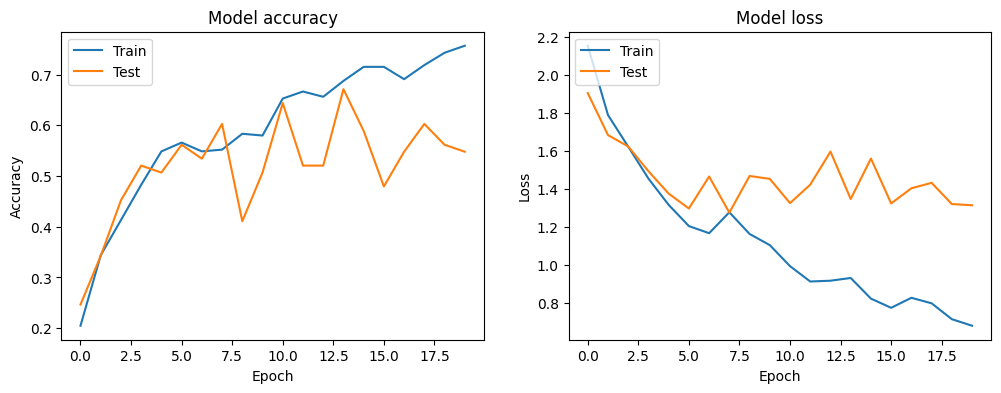

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [58]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

3/3 [==============================] - 0s 28ms/step


In [59]:
y_pred_classes = y_pred_classes.astype(int)

In [60]:
y_pred_classes

array([2, 6, 2, 9, 2, 5, 4, 7, 5, 2, 1, 2, 8, 7, 1, 5, 8, 8, 9, 4, 6, 5,
       4, 5, 9, 5, 2, 5, 2, 9, 2, 4, 6, 9, 5, 2, 2, 6, 2, 5, 2, 9, 2, 5,
       4, 9, 4, 2, 5, 2, 8, 7, 5, 7, 7, 9, 4, 2, 8, 5, 8, 8, 7, 6, 5, 7,
       8, 2, 4, 7, 7, 9, 7])

In [61]:
y_test_encoded

array([5, 6, 6, 9, 7, 5, 7, 2, 1, 2, 1, 6, 8, 7, 2, 5, 8, 8, 9, 4, 6, 5,
       7, 0, 9, 5, 8, 5, 2, 9, 6, 4, 6, 9, 2, 2, 7, 6, 3, 5, 8, 9, 6, 0,
       4, 9, 4, 7, 6, 6, 8, 2, 0, 8, 5, 9, 4, 6, 0, 7, 9, 8, 7, 6, 1, 7,
       8, 2, 3, 7, 4, 9, 3])

In [62]:
# Now compute precision, recall, and F1-score
precision, recall, f1score, support = precision_recall_fscore_support(y_test_encoded, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1score}")
print(f"Support: {support}")
print(f"Accuracy: {accuracy}")

Precision: 0.5933003338321631
Recall: 0.547945205479452
F1-score: 0.5382849255583467
Support: None
Accuracy: 0.547945205479452


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
class_names = ['AnnualCrop','Forest', 'HerbaceousVegetation',
                 'Highway', 'Industrial', 'Pasture',
                 'PermanentCrop', 'Residential', 'River',
                 'SeaLake']

In [64]:
from sklearn.metrics import classification_report

# Get the predicted probabilities
y_pred_prob = model.predict(x_test)

# Get the predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = y_test_encoded  # Replace with your true labels
import pandas as pd
# Print the classification report
report = classification_report(y_true, y_pred, target_names=class_names,output_dict=True)
report = pd.DataFrame(report).transpose()
print(report)

3/3 [==============================] - 0s 24ms/step
                      precision    recall  f1-score    support
AnnualCrop             0.000000  0.000000  0.000000   4.000000
Forest                 0.500000  0.333333  0.400000   3.000000
HerbaceousVegetation   0.235294  0.500000  0.320000   8.000000
Highway                0.000000  0.000000  0.000000   3.000000
Industrial             0.625000  0.833333  0.714286   6.000000
Pasture                0.428571  0.750000  0.545455   8.000000
PermanentCrop          1.000000  0.416667  0.588235  12.000000
Residential            0.400000  0.400000  0.400000  10.000000
River                  0.750000  0.666667  0.705882   9.000000
SeaLake                1.000000  0.900000  0.947368  10.000000
accuracy               0.547945  0.547945  0.547945   0.547945
macro avg              0.493887  0.480000  0.462123  73.000000
weighted avg           0.593300  0.547945  0.538285  73.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


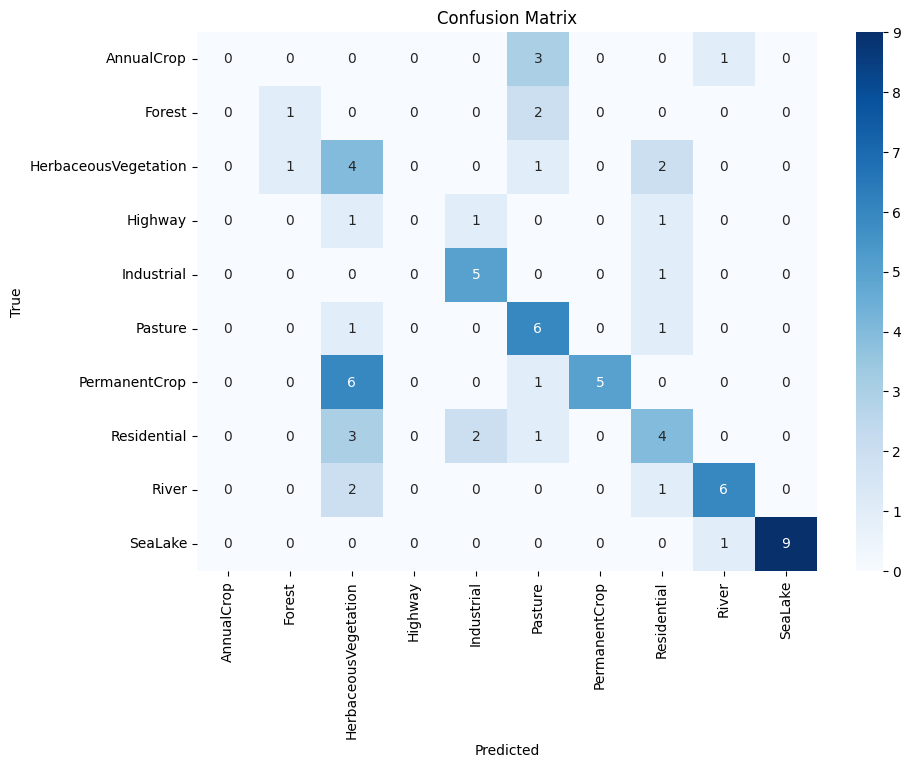

In [65]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [66]:
model.save("13_band.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [67]:
!pip install shap

In [68]:
import shap

In [69]:
background = x_train[np.random.choice(x_train.shape[0], 10, replace=False)]
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test[1:5])

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [70]:
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]

# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

x_test_each_class tensor has shape: (10, 64, 64, 13)


In [71]:
shap_values = e.shap_values(x_test[:5])

In [72]:
average_shap_values = np.mean(shap_values)

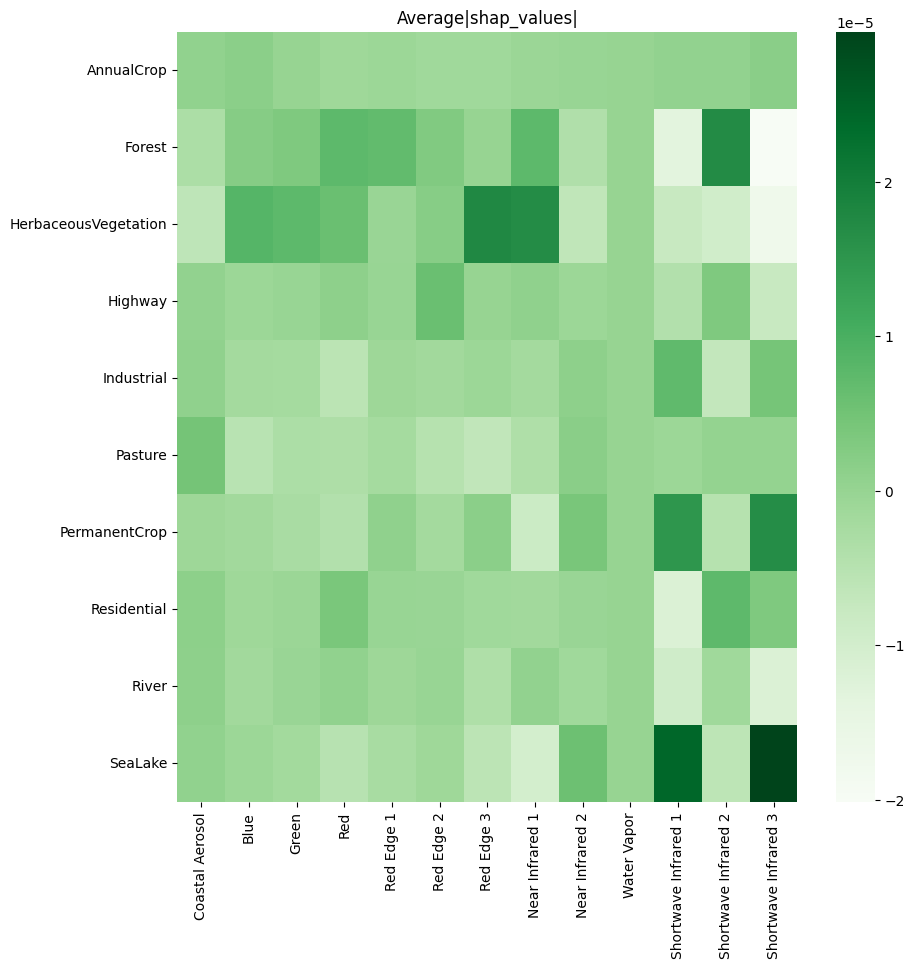

In [73]:
avg_shap_values = shap_values.mean(axis=(0, 1, 2))
import pandas as pd
# Convert the 2D array to a DataFrame for easier plotting
df = pd.DataFrame(avg_shap_values.T, columns=["Coastal Aerosol", "Blue", "Green", "Red", "Red Edge 1", "Red Edge 2", "Red Edge 3", "Near Infrared 1", "Near Infrared 2", "Water Vapor", "Shortwave Infrared 1", "Shortwave Infrared 2", "Shortwave Infrared 3"], index=class_names)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df,cmap='Greens')
plt.title('Average|shap_values|')
plt.show()

In [74]:
spectral_bands = ["Coastal Aerosol", "Blue", "Green", "Red", "Red Edge 1", "Red Edge 2", "Red Edge 3", "Near Infrared 1", "Near Infrared 2", "Water Vapor", "Shortwave Infrared 1", "Shortwave Infrared 2", "Shortwave Infrared 3"]